# Import libraries

In [1]:
!pip install pandas_ta
!pip install torch torchvision

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas_ta as ta
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import random
from copy import deepcopy

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(23)

# Data Preparation

In [4]:
ibm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Trading/Data/IBM_weekly.csv')

In [5]:
ibm.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## Target Construct

In [6]:
# Create Log(Return)
import numpy as np
# Calculate logarithmic returns
ibm['Log_Return'] = np.log(ibm['Close'] / ibm['Close'].shift(1))
ibm['Log_Return'].fillna(0, inplace=True)  # Handle NaN values resulting from the shift

## Covariates construct

In [7]:
# Calculate Simple Moving Average (SMA)
ibm['SMA_50'] = ta.sma(ibm['Close'], length=50)  # 50-period SMA
ibm['SMA_200'] = ta.sma(ibm['Close'], length=200)  # 200-period SMA

# Calculate Exponential Moving Average (EMA)
ibm['EMA_12'] = ta.ema(ibm['Close'], length=12)  # 12-period EMA
ibm['EMA_26'] = ta.ema(ibm['Close'], length=26)  # 26-period EMA

# Calculate the Stochastic Oscillator components
stoch = ta.stoch(ibm['High'], ibm['Low'], ibm['Close'])
ibm = ibm.join(stoch)

# Calculate Relative Strength Index (RSI)
ibm['RSI_14'] = ta.rsi(ibm['Close'], length=14)  # 14-period RSI

# Calculate Moving Average Convergence Divergence (MACD)
macd = ta.macd(ibm['Close'])
ibm = ibm.join(macd)

In [8]:
ibm['Date'] = pd.to_datetime(ibm['Date'])
ibm.set_index('Date', inplace=True)

In [9]:
# Handle NaN:
ibm.dropna(inplace=True)

In [10]:
ibm.shape

(1367, 16)

## Split

In [11]:
dates = ibm.index

In [12]:
# Calculate split indices
split_idx_train = int(len(ibm) * 0.7)
split_idx_val = int(len(ibm) * 0.9)

# Drop the specified columns and define the features and labels
X_ibm = ibm.drop(['Log_Return'], axis=1)
y_ibm = ibm['Log_Return']  # Log_Return as the target variable

# Ensure that indices are reset before splitting to avoid potential issues
X_ibm.reset_index(drop=True, inplace=True)
y_ibm.reset_index(drop=True, inplace=True)

# Split into training, validation, and testing sets
X_ibm_train = X_ibm.iloc[:split_idx_train, :]
X_ibm_val = X_ibm.iloc[split_idx_train:split_idx_val, :]
X_ibm_test = X_ibm.iloc[split_idx_val:, :]

y_ibm_train = y_ibm.iloc[:split_idx_train]
y_ibm_val = y_ibm.iloc[split_idx_train:split_idx_val]
y_ibm_test = y_ibm.iloc[split_idx_val:]

In [13]:
ibm_dates_test = dates[split_idx_val:]

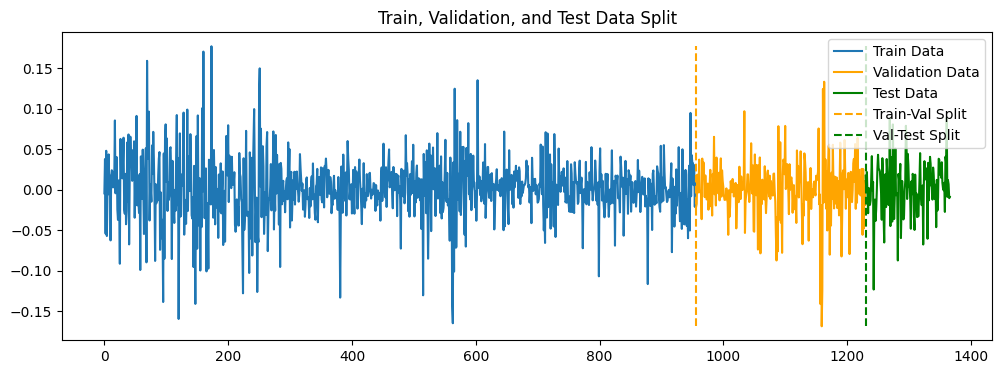

In [14]:
# Indices for plotting
x_train = np.arange(len(y_ibm_train))
x_val = np.arange(len(y_ibm_train), len(y_ibm_train) + len(y_ibm_val))
x_test = np.arange(len(y_ibm_train) + len(y_ibm_val), len(y_ibm))

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(x_train, y_ibm_train, label="Train Data")
plt.plot(x_val, y_ibm_val, color='orange', label="Validation Data")
plt.plot(x_test, y_ibm_test, color='green', label="Test Data")
plt.vlines(len(y_ibm_train), ymin=min(y_ibm.min(), y_ibm.min(), y_ibm.min()), ymax=max(y_ibm.max(), y_ibm.max(), y_ibm.max()), label='Train-Val Split', linestyles='dashed', colors='orange')
plt.vlines(len(y_ibm_train) + len(y_ibm_val), ymin=min(y_ibm.min(), y_ibm.min(), y_ibm.min()), ymax=max(y_ibm.max(), y_ibm.max(), y_ibm.max()), label='Val-Test Split', linestyles='dashed', colors='green')
plt.legend()
plt.title("Train, Validation, and Test Data Split")
plt.show()

# Data Preprocessing

In [15]:
from sklearn.preprocessing import power_transform

# Fit the transformer on the training data and transform it
X_ibm_train_transformed = power_transform(X_ibm_train.to_numpy(), method='yeo-johnson')

# Transform the validation data using the same transformer
X_ibm_val_transformed = power_transform(X_ibm_val.to_numpy(), method='yeo-johnson')

# Transform the test data using the same transformer
X_ibm_test_transformed = power_transform(X_ibm_test.to_numpy(), method='yeo-johnson')

In [16]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_ibm_train_scaled = scaler.fit_transform(X_ibm_train_transformed)

# Transform the val data using the same scaler
X_ibm_val_scaled = scaler.transform(X_ibm_val_transformed)

# Transform the test data using the same scaler
X_ibm_test_scaled = scaler.transform(X_ibm_test_transformed)

In [17]:
print(X_ibm_train_scaled.shape)
print(X_ibm_val_scaled.shape)
print(X_ibm_test_scaled.shape)

(956, 15)
(274, 15)
(137, 15)


# Models

In [18]:
!ls "/content/drive/My Drive/Colab Notebooks/Trading"

01_Strategy_Optimization.ipynb	anns.py     Data			lstm.py
anns.ipynb			arma.ipynb  IBM_price_prediction.ipynb	__pycache__


In [19]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Trading')
from anns import EnhancedSignAgreementLoss, rnns, create_sequences_rnns, SimpleRNN, RMSELoss

In [20]:
# Ensure y_ibm_train and y_test are numpy arrays
y_ibm_train = y_ibm_train.to_numpy() if isinstance(y_ibm_train, pd.Series) else y_ibm_train
y_ibm_val = y_ibm_val.to_numpy() if isinstance(y_ibm_val, pd.Series) else y_ibm_val
y_ibm_test = y_ibm_test.to_numpy() if isinstance(y_ibm_test, pd.Series) else y_ibm_test

# Create sequences
time_steps = 10
X_ibm_train_seq, y_ibm_train_seq = create_sequences_rnns(X_ibm_train_scaled, y_ibm_train, time_steps)
X_ibm_val_seq, y_ibm_val_seq = create_sequences_rnns(X_ibm_val_scaled, y_ibm_val, time_steps)
X_ibm_test_seq, y_ibm_test_seq = create_sequences_rnns(X_ibm_test_scaled, y_ibm_test, time_steps)

X_ibm_train_tensor = torch.tensor(X_ibm_train_seq, dtype=torch.float32)
y_ibm_train_tensor = torch.tensor(y_ibm_train_seq, dtype=torch.float32)
X_ibm_val_tensor = torch.tensor(X_ibm_val_seq, dtype=torch.float32)
y_ibm_val_tensor = torch.tensor(y_ibm_val_seq, dtype=torch.float32)
X_ibm_test_tensor = torch.tensor(X_ibm_test_seq, dtype=torch.float32)
y_ibm_test_tensor = torch.tensor(y_ibm_test_seq, dtype=torch.float32)

# Prepare data loaders
ibm_train_dataset = TensorDataset(X_ibm_train_tensor, y_ibm_train_tensor)
ibm_train_loader = DataLoader(dataset=ibm_train_dataset, batch_size=32, shuffle=True)
ibm_val_dataset = TensorDataset(X_ibm_val_tensor, y_ibm_val_tensor)
ibm_val_loader = DataLoader(dataset=ibm_val_dataset, batch_size=32, shuffle=False)

# Prepare data for prediction
ibm_predict_dataset = TensorDataset(X_ibm_test_tensor, y_ibm_test_tensor)
ibm_predict_loader = DataLoader(ibm_predict_dataset, batch_size=32, shuffle=False)

In [21]:
X_ibm_train_tensor.shape

torch.Size([946, 10, 15])

## RMSE

### RNNs

In [22]:
# Initialize the RNN model
ibm_rnns_rmse = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(ibm_rnns_rmse.parameters(), lr=0.001)
loss_function = RMSELoss()
epochs = 100

best_model_state, best_val_loss = rnns(ibm_rnns_rmse, ibm_train_loader, ibm_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 0.05155012384057045, Val Loss: 0.09110002964735031
Epoch 11, Train Loss: 0.05463177710771561, Val Loss: 0.049604129046201706
Epoch 21, Train Loss: 0.03995973989367485, Val Loss: 0.04819263517856598
Epoch 31, Train Loss: 0.0376192182302475, Val Loss: 0.04459325596690178
Epoch 41, Train Loss: 0.03294532746076584, Val Loss: 0.04541568458080292
Epoch 51, Train Loss: 0.025168927386403084, Val Loss: 0.0430135503411293
Epoch 61, Train Loss: 0.034948527812957764, Val Loss: 0.04505909979343414
Epoch 71, Train Loss: 0.042867109179496765, Val Loss: 0.04375271499156952
Epoch 81, Train Loss: 0.029051294550299644, Val Loss: 0.04329628497362137
Epoch 91, Train Loss: 0.038347840309143066, Val Loss: 0.04458039999008179


In [23]:
best_val_loss

tensor(0.0417)

In [24]:
ibm_rnns_rmse.load_state_dict(best_model_state)
ibm_rnns_rmse.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [25]:
ibm_predictions = []
ibm_actuals = []

with torch.no_grad():
    for inputs, labels in ibm_predict_loader:
        outputs = ibm_rnns_rmse(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        ibm_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        ibm_actuals.extend(labels.cpu().numpy())

In [26]:
ibm_rnns_rmse_predictions = np.array(ibm_predictions)
ibm_rnns_rmse_actuals = np.array(ibm_actuals)

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming ibm_rnns_rmse_predictions and ibm_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
ibm_rnns_rmse_predicted_labels = (ibm_rnns_rmse_predictions >= 0).astype(int)
ibm_rnns_rmse_actual_labels = (ibm_rnns_rmse_actuals >= 0).astype(int)

# Calculate classifier metrics
ibm_rnns_rmse_accuracy = accuracy_score(ibm_rnns_rmse_actual_labels, ibm_rnns_rmse_predicted_labels)
ibm_rnns_rmse_precision = precision_score(ibm_rnns_rmse_actual_labels, ibm_rnns_rmse_predicted_labels)
ibm_rnns_rmse_recall = recall_score(ibm_rnns_rmse_actual_labels, ibm_rnns_rmse_predicted_labels)
ibm_rnns_rmse_f1 = f1_score(ibm_rnns_rmse_actual_labels, ibm_rnns_rmse_predicted_labels)

# Print the classification metrics
print("Accuracy:", ibm_rnns_rmse_accuracy)
print("Precision:", ibm_rnns_rmse_precision)
print("Recall:", ibm_rnns_rmse_recall)
print("F1 Score:", ibm_rnns_rmse_f1)

Accuracy: 0.5118110236220472
Precision: 0.5555555555555556
Recall: 0.4411764705882353
F1 Score: 0.49180327868852464


### LSTM

In [28]:
from anns import LSTMModel, lstm, evaluate_signs

In [83]:
# Parameters
input_size = 15
hidden_size = 50  # Number of features in hidden state
num_layers = 2  # Number of stacked LSTM layers
output_size = 1  # Number of output classes
epochs = 100
# Model initialization
ibm_lstm_rmse = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
loss_function = RMSELoss()
optimizer = torch.optim.Adam(ibm_lstm_rmse.parameters(), lr=0.001)

# Execute training
best_model_state, best_val_loss = lstm(ibm_lstm_rmse, ibm_train_loader, ibm_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 0.042689438164234164, Val Loss: 0.03489395541449388
Epoch 11, Train Loss: 0.036466063124438126, Val Loss: 0.034207584543360606
Epoch 21, Train Loss: 0.03581572876622279, Val Loss: 0.035073702327079244
Epoch 31, Train Loss: 0.03514443257202705, Val Loss: 0.03714979957375261
Epoch 41, Train Loss: 0.03374106405923764, Val Loss: 0.03919527493417263
Epoch 51, Train Loss: 0.03280066841592391, Val Loss: 0.044075064154134855
Epoch 61, Train Loss: 0.02862385070572297, Val Loss: 0.04637454884747664
Epoch 71, Train Loss: 0.0249844241887331, Val Loss: 0.05062257871031761
Epoch 81, Train Loss: 0.022123736484597128, Val Loss: 0.056073587801721364
Epoch 91, Train Loss: 0.0194060731989642, Val Loss: 0.05979088652465078
Final Best Validation Loss: 0.03313779913716846


In [84]:
ibm_lstm_rmse.load_state_dict(best_model_state)
ibm_lstm_rmse.to('cuda' if torch.cuda.is_available() else 'cpu')

LSTMModel(
  (lstm): LSTM(15, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [85]:
accuracy, precision, recall, f1 = evaluate_signs(ibm_lstm_rmse, ibm_predict_loader)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.5196850393700787
Precision: 0.5853658536585366
Recall: 0.35294117647058826
F1 Score: 0.44036697247706424


## Custom loss function

### RNN

In [32]:
from anns import EnhancedSignAgreementLoss
# Initialize the RNN model
ibm_rnns_custom = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(ibm_rnns_custom.parameters(), lr=0.001)
loss_function = EnhancedSignAgreementLoss(loss_penalty=10000)
epochs = 100

best_model_state, best_val_loss = rnns(ibm_rnns_custom, ibm_train_loader, ibm_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 5000.005859375, Val Loss: 5000.005859375
Epoch 11, Train Loss: 5000.00048828125, Val Loss: 5416.66796875
Epoch 21, Train Loss: 4444.44482421875, Val Loss: 5104.16845703125
Epoch 31, Train Loss: 5000.001953125, Val Loss: 5625.001953125
Epoch 41, Train Loss: 5555.55615234375, Val Loss: 5138.89013671875
Epoch 51, Train Loss: 5555.55712890625, Val Loss: 5277.779296875
Epoch 61, Train Loss: 5000.001953125, Val Loss: 5208.33447265625
Epoch 71, Train Loss: 2777.7783203125, Val Loss: 5104.16845703125
Epoch 81, Train Loss: 5555.5556640625, Val Loss: 4930.55712890625
Epoch 91, Train Loss: 2222.22314453125, Val Loss: 5208.3349609375


In [33]:
best_val_loss

tensor(4687.5010)

In [34]:
ibm_rnns_custom.load_state_dict(best_model_state)
ibm_rnns_custom.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [35]:
ibm_predictions = []
ibm_actuals = []

with torch.no_grad():
    for inputs, labels in ibm_predict_loader:
        outputs = ibm_rnns_custom(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        ibm_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        ibm_actuals.extend(labels.cpu().numpy())

In [36]:
ibm_rnns_custom_predictions = np.array(ibm_predictions)
ibm_rnns_custom_actuals = np.array(ibm_actuals)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming ibm_rnns_rmse_predictions and ibm_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
ibm_rnns_custom_predicted_labels = (ibm_rnns_custom_predictions >= 0).astype(int)
ibm_rnns_custom_actual_labels = (ibm_rnns_custom_actuals >= 0).astype(int)

# Calculate classifier metrics
ibm_rnns_custom_accuracy = accuracy_score(ibm_rnns_custom_actual_labels, ibm_rnns_custom_predicted_labels)
ibm_rnns_custom_precision = precision_score(ibm_rnns_custom_actual_labels, ibm_rnns_custom_predicted_labels)
ibm_rnns_custom_recall = recall_score(ibm_rnns_custom_actual_labels, ibm_rnns_custom_predicted_labels)
ibm_rnns_custom_f1 = f1_score(ibm_rnns_custom_actual_labels, ibm_rnns_custom_predicted_labels)

# Print the classification metrics
print("Accuracy:", ibm_rnns_custom_accuracy)
print("Precision:", ibm_rnns_custom_precision)
print("Recall:", ibm_rnns_custom_recall)
print("F1 Score:", ibm_rnns_custom_f1)

Accuracy: 0.5354330708661418
Precision: 0.5737704918032787
Recall: 0.5147058823529411
F1 Score: 0.5426356589147286


### LSTM

In [80]:
# Parameters
input_size = 15
hidden_size = 50  # Number of features in hidden state
num_layers = 2  # Number of stacked LSTM layers
output_size = 1  # Number of output classes
epochs = 100
# Model initialization
ibm_lstm_custom = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
loss_function = EnhancedSignAgreementLoss(loss_penalty=10000)
optimizer = torch.optim.Adam(ibm_lstm_custom.parameters(), lr=0.001)

# Execute training
best_model_state, best_val_loss = lstm(ibm_lstm_custom, ibm_train_loader, ibm_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 4707.1775390625, Val Loss: 4791.667751736111
Epoch 11, Train Loss: 4643.519742838542, Val Loss: 5138.889838324652
Epoch 21, Train Loss: 4288.195581054688, Val Loss: 5104.167697482639
Epoch 31, Train Loss: 4157.408561197916, Val Loss: 5243.056911892361
Epoch 41, Train Loss: 3972.2232421875, Val Loss: 4513.890407986111
Epoch 51, Train Loss: 3421.2971435546874, Val Loss: 5000.002115885417
Epoch 61, Train Loss: 3369.213663736979, Val Loss: 4930.557725694444
Epoch 71, Train Loss: 2907.4079752604166, Val Loss: 4930.558322482639
Epoch 81, Train Loss: 2788.194921875, Val Loss: 4791.670166015625
Epoch 91, Train Loss: 2475.694755045573, Val Loss: 4583.337510850694
Final Best Validation Loss: 4409.726915147569


In [81]:
ibm_lstm_custom.load_state_dict(best_model_state)
ibm_lstm_custom.to('cuda' if torch.cuda.is_available() else 'cpu')

LSTMModel(
  (lstm): LSTM(15, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [82]:
accuracy, precision, recall, f1 = evaluate_signs(ibm_lstm_custom, ibm_predict_loader)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.5433070866141733
Precision: 0.5892857142857143
Recall: 0.4852941176470588
F1 Score: 0.532258064516129
